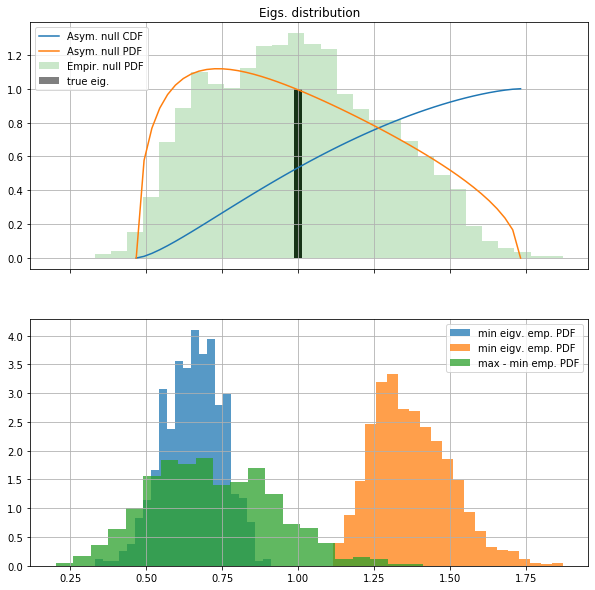

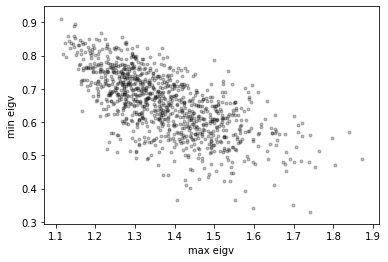

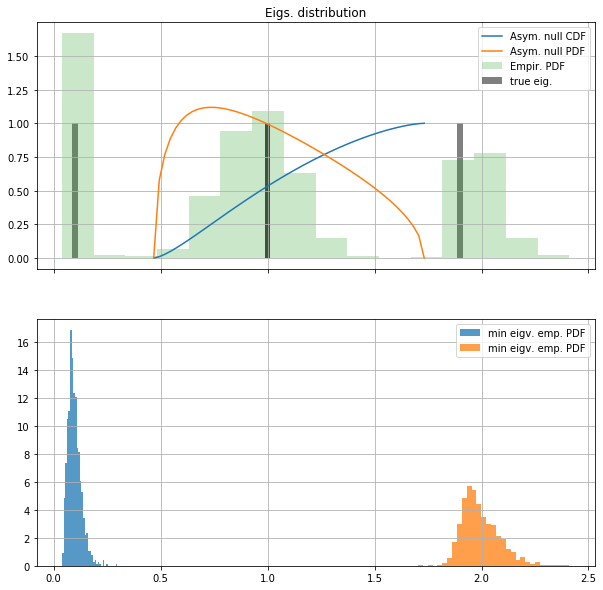

In [52]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import marchenko_pastur as mp


p = 4
n = 10*p
nsim = 1000
mpdist = mp.marchenko_pastur(p, n)

mcorr0 = np.eye(p)
mcorr1 = mcorr0.copy()
#mcorr1[0,1]=mcorr1[1,0] = 0.2
#mcorr1[0,2]=mcorr1[2,0] = 0.3
#mcorr1[1,2]=mcorr1[2,1] = 0.4
mcorr1[0,1] = 0.9
mcorr1[1,0] = 0.9


#wh = np.linalg.inv(mcorr1[1::][:,1::]) @ mcorr1[1::,0]
#mvh = np.
#k = 1/0


if 0:
    mcorr1 = np.array(
        [
            [1.00, 0.26, 0.41, 0.57],
            [0.26, 1.00, 0.19, 0.33],
            [0.41, 0.19, 1.00, 0.52],
            [0.57, 0.33, 0.52, 1.00]
        ])


#vol = np.ones(p)
#mcov = np.diag(vol) @ mcorr @ np.diag(vol)
gen0 = stats.multivariate_normal(cov=mcorr0)
gen1 = stats.multivariate_normal(cov=mcorr1)


gen = [gen0, gen1]
# estimators
def simulate(g):
    data_eig = np.empty((nsim, p))
    for i in range(nsim):
        mcorr_hat = np.corrcoef(g.rvs(n), rowvar=False)
        eigs = np.linalg.eigvals(mcorr_hat)
        data_eig[i] = eigs
    return data_eig

eig0 = simulate(gen0)
eig1 = simulate(gen1)


x = np.linspace(mpdist.lbound(), mpdist.ubound(), 50)


# ====
if 0:
    plt.figure(figsize=(8,2))
    plt.bar(np.linalg.eigvals(mcorr0), np.ones(p), width=0.025, alpha=0.5, color='k', label='true eig.')
    title = 'Eigs. distribution,  $\\gamma$ = {}/{}'.format(p, n)
    plt.title(title, fontsize=15)
    plt.plot(x, mpdist.pdf(x), label='MP')
    plt.hist(eig0.flatten(), bins='auto', density=True, alpha=0.25, label='Empir. null PDF', color='g')
    plt.xlabel('$\\lambda$', fontsize=15)
    plt.grid()
    plt.legend()
    k = 1/0
# ====

# ==== H0 =====
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
axs[0].bar(np.linalg.eigvals(mcorr0), np.ones(p), width=0.025, alpha=0.5, color='k', label='true eig.')
axs[0].set_title('Eigs. distribution')
axs[0].plot(x, mpdist.cdf(x), label='Asym. null CDF')
axs[0].plot(x, mpdist.pdf(x), label='Asym. null PDF')
axs[0].hist(eig0.flatten(), bins='auto', density=True, alpha=0.25, label='Empir. null PDF')

#axs[1].set_title('Min Max eigv. emp. dist')
axs[1].hist(np.min(eig0, axis=1), bins='auto', density=True, alpha=0.75, label='min eigv. emp. PDF')
axs[1].hist(np.max(eig0, axis=1), bins='auto', density=True, alpha=0.75, label='min eigv. emp. PDF')
axs[1].hist(np.max(eig0, axis=1)-np.min(eig0, axis=1), bins='auto', density=True, alpha=0.75, label='max - min emp. PDF')

for ax in axs:
    ax.grid(True); ax.legend(loc='best')
    
plt.figure()
plt.scatter(np.max(eig0, axis=1), np.min(eig0, axis=1), c='k', marker='.', alpha='0.25')
plt.xlabel('max eigv')
plt.ylabel('min eigv')


# ==== H1 =====
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
axs[0].bar(np.linalg.eigvals(mcorr1), np.ones(p), width=0.025, alpha=0.5, color='k', label='true eig.')

axs[0].set_title('Eigs. distribution')
axs[0].plot(x, mpdist.cdf(x), label='Asym. null CDF')
axs[0].plot(x, mpdist.pdf(x), label='Asym. null PDF')
axs[0].hist(eig1.flatten(), bins='auto', density=True, alpha=0.25, label='Empir. PDF')
axs[0].grid(True); axs[0].legend(loc='best')

#axs[1].set_title('Min Max eigv. emp. dist')
axs[1].hist(np.min(eig1, axis=1), bins='auto', density=True, alpha=0.75, label='min eigv. emp. PDF')
axs[1].hist(np.max(eig1, axis=1), bins='auto', density=True, alpha=0.75, label='min eigv. emp. PDF')

for ax in axs:
    ax.grid(True); ax.legend(loc='best')

plt.show()

In [60]:
def mp_cut(mcorr, n, p, cut_low=False):
    #print('===== true corr =====')
    #print(mcorr1)
    #print('===== true corr eigs =====')
    #print( np.linalg.eigvals(mcorr1) )
    
    # ===== est =====
    #hh = gen1.rvs(n)
    #hcorr = np.corrcoef(hh,rowvar=False)
    #print('Fro norm naive {}'.format( np.linalg.norm(hcorr - mcorr1, 'fro') ))
    ub = (1 + (p/n)**0.5)**2
    lb = (1 -(p/n)**0.5)**2
    u,d,vt = np.linalg.svd(mcorr)
    
    #print('===== cut =====')
    if cut_low:
        k = (d < ub) & (lb<d)
    else:
        k = (d < ub)
    
    gamma = d[k].mean()
    d[k] = gamma
    #d[~k] *= 0.8
    corr_cln = u @ np.diag(d) @ vt
    corr_cln = np.diag(1/np.diag(corr_cln)**0.5) @ corr_cln @ np.diag(1/np.diag(corr_cln)**0.5)
    #print('===== cleaned matrix =====')
    #print('Fro norm new {}'.format( np.linalg.norm(corr_cln - mcorr1, 'fro') ))
    #print('Fro norm I {}'.format( np.linalg.norm(np.eye(mcorr1.shape[0]) - mcorr1, 'fro') ))
    return corr_cln


def mvp(mcov):
    wh = -np.linalg.inv(mcov[1::][:,1::]) @ mcov[1::,0]
    wh = np.concatenate(([1], wh))
    return wh
    
    
    
w_true = mvp(mcorr1)
var_optim = w_true @ mcorr1 @ w_true

from src.estimation.cov_cleaning import RIE, mp_denoise
    
nsim = 1000
n = p*5
# estimators
res = np.zeros((nsim, 2))
for i in range(nsim):
    mcov_hat = np.cov(gen1.rvs(n), rowvar=False, ddof=1)
    w0 = mvp(mcov_hat)
    var0 = w0 @ mcorr1 @ w0
    
    var_est = np.diag(mcov_hat)
    corr_est = np.diag(1/var_est**0.5) @ mcov_hat @ np.diag(1/var_est**0.5)
    corr_cln = mp_cut(corr_est, n, p, cut_low=True)
    #corr_cln = RIE(corr_est, p, n)
    cov_cln = np.diag(var_est**0.5) @ corr_cln @ np.diag(var_est**0.5)
    w1 = mvp(cov_cln)
    var1 = w1 @ mcorr1 @ w1
    
    res[i,0] = var0
    res[i,1] = var1

print(np.mean(res, axis=0))
print(var_optim)

[0.22814355 0.24157155]
0.18999999999999995
